In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Acceder a la string de conexion desde el archivo .env
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")

# Definir el string de la conexión
connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Crear el SQLAlchemy engine
engine = create_engine(connection_string)

# Crear y manejar una conexión manual
connection = engine.connect()

# Cargar el dataset en un dataframe de Pandas
bank_account_fraud_df = pd.read_sql("SELECT * FROM preprocessed_data", connection)


# Cerrar la conexión
connection.close()
print("PostgreSQL connection is closed.")

# Mostrar las primeras filas de la base de datos
bank_account_fraud_df.head()

PostgreSQL connection is closed.


,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,25.0,40,0.006735,AA,1059,13096.035018,7850.955007,...,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0,0
1,0,0.8,0.617426,89.0,20,0.010095,AD,1658,9223.283431,5745.251481,...,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0,0
2,0,0.8,0.996707,14.0,40,0.012316,AB,1095,4471.472149,5471.988958,...,0,200.0,0,INTERNET,22.730559,windows,0,1.0,0,0
3,0,0.6,0.475100,14.0,30,0.006991,AB,3483,14431.993621,6755.344479,...,0,200.0,0,INTERNET,15.215816,linux,1,1.0,0,0
4,0,0.9,0.842307,29.0,40,5.742626,AA,2339,7601.511579,5124.046930,...,0,200.0,0,INTERNET,3.743048,other,0,1.0,0,0


### **Paso 1:** Separar el dataset en variables categoricas y variables númericas

In [2]:
# Variables categoricas
baf_cat = bank_account_fraud_df[['payment_type','employment_status','housing_status','source','device_os']]

#Variables númericas
baf_num = bank_account_fraud_df.drop(columns=['payment_type','employment_status','housing_status','source','device_os'])

### **Paso 2:** Análisis de las variables categóricas

In [3]:
# Información de las variables categóricas
baf_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   payment_type       1000000 non-null  object
 1   employment_status  1000000 non-null  object
 2   housing_status     1000000 non-null  object
 3   source             1000000 non-null  object
 4   device_os          1000000 non-null  object
dtypes: object(5)
memory usage: 38.1+ MB


#### **Información de las variables categóricas**
- Existen cuatro variables categóricas en el dataset
- Las variables son del tipo object.
- Los atributos se encuentran completos.

In [4]:
# Frecuencia de valores unicos de las variables categoricas
for col in baf_cat.columns:
    print(f"Cantidad de valores únicos de {col}: ", baf_cat[col].nunique())
    print(f"Valores unicos de {col}: ", baf_cat[col].unique())

Cantidad de valores únicos de payment_type:  5
Valores unicos de payment_type:  ['AA' 'AD' 'AB' 'AC' 'AE']
Cantidad de valores únicos de employment_status:  7
Valores unicos de employment_status:  ['CB' 'CA' 'CC' 'CF' 'CD' 'CE' 'CG']
Cantidad de valores únicos de housing_status:  7
Valores unicos de housing_status:  ['BC' 'BE' 'BD' 'BA' 'BB' 'BF' 'BG']
Cantidad de valores únicos de source:  2
Valores unicos de source:  ['INTERNET' 'TELEAPP']
Cantidad de valores únicos de device_os:  5
Valores unicos de device_os:  ['linux' 'other' 'windows' 'x11' 'macintosh']


#### **Frecuencia de los valores únicos de cada variable**
- ***payment_type:*** tiene cinco valores únicos que corresponden a: 'AA' 'AD' 'AB' 'AC' 'AE'
- ***employment_status:*** tiene siete valores únicos que corresponden a: 'CB' 'CA' 'CC' 'CF' 'CD' 'CE' 'CG'
- ***housing_status:*** tiene siete valores únicos que corresponden a: 'BC' 'BE' 'BD' 'BA' 'BB' 'BF' 'BG'
- ***source:*** tiene dos valores únicos que corresponden a: 'INTERNET' 'TELEAPP'

In [5]:
# Calcular la frecuencia de cada valor único
baf_cat_freq = []

for col in baf_cat.columns:
    frequency_table = baf_cat[col].value_counts().sort_index().reset_index()
    frequency_table.columns = [col, 'count']
    frequency_table['percentage'] = (frequency_table['count'] / baf_cat[col].count()) * 100
    baf_cat_freq.append(frequency_table)

# Mostrar cada tabla de frecuencias
for freq_table in baf_cat_freq:
    print(freq_table)
    print("\n")

  payment_type   count  percentage
0           AA  258249     25.8249
1           AB  370554     37.0554
2           AC  252071     25.2071
3           AD  118837     11.8837
4           AE     289      0.0289


  employment_status   count  percentage
0                CA  730252     73.0252
1                CB  138288     13.8288
2                CC   37758      3.7758
3                CD   26522      2.6522
4                CE   22693      2.2693
5                CF   44034      4.4034
6                CG     453      0.0453


  housing_status   count  percentage
0             BA  169675     16.9675
1             BB  260965     26.0965
2             BC  372143     37.2143
3             BD   26161      2.6161
4             BE  169135     16.9135
5             BF    1669      0.1669
6             BG     252      0.0252


     source   count  percentage
0  INTERNET  992952     99.2952
1   TELEAPP    7048      0.7048


   device_os   count  percentage
0      linux  332712     33.2712
1  m

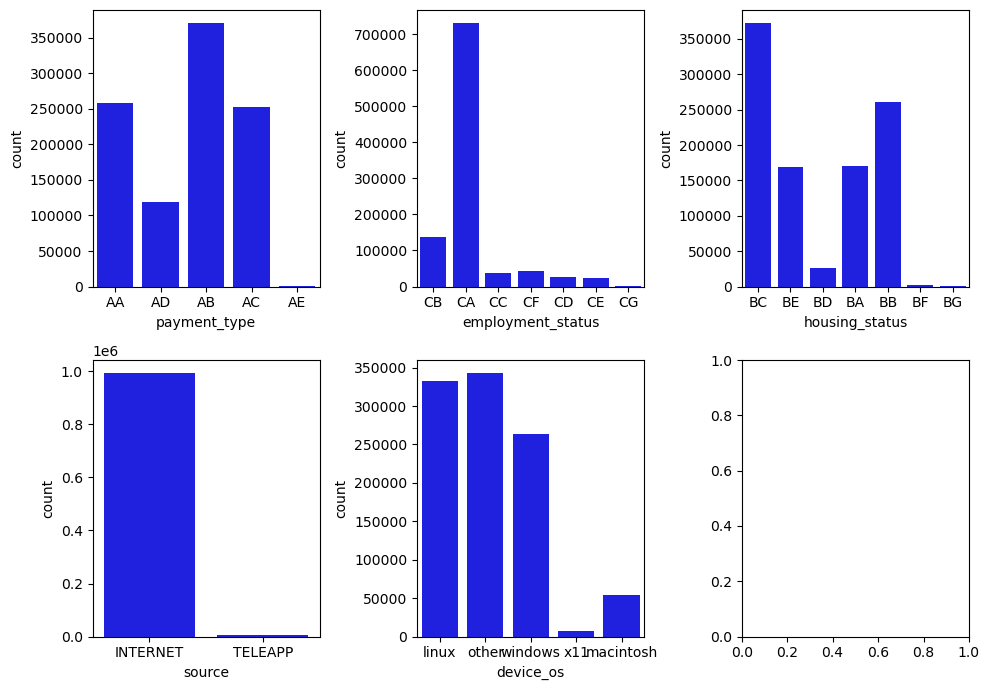

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de las variables categóricas
fig, axis = plt.subplots(2, 3, figsize = (10, 7))

# Create a multiple histogram
sns.countplot(ax = axis[0, 0], data = baf_cat, x = "payment_type", color='blue')
sns.countplot(ax = axis[0, 1], data = baf_cat, x = "employment_status", color='blue')
sns.countplot(ax = axis[0, 2], data = baf_cat, x = "housing_status", color='blue')
sns.countplot(ax = axis[1, 0], data = baf_cat, x = "source", color='blue')
sns.countplot(ax = axis[1, 1], data = baf_cat, x = "device_os", color='blue')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


#### **Análisis de las variables categóricas**
- Con respecto a la **forma de pago *(payment_type)***, la forma *'AB'* con 37.06% es la más usada. Por otra parte, la forma *'AE'* el uso responde a menos del 1% siendo la forma menos usada.
- La mayoría de las solicitudes son realizadas por usuarios con **situación laboral *(employment_status)*** *'CA'*, representando un 73.02%, mientras que las demás situaciones representan el menos del 27% de los solicitantes.
- En cuanto a la **situación de vivienda *(housing_status)*** muestra que las situaciones *'BD'*, *'BF'* y *'BG'* serian las situaciones minoritarias, mientras que los solicitantes con situación *'BC'* son los que mayormente realizan solicitudes.
- Por último, la mayor parte de las aplicaciones se realizan por **medio *(source)*** de INTERNET.

### **Paso 3:** Análisis de las variables numéricas

In [7]:
# Información de las variables categóricas
baf_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   current_address_months_count      1000000 non-null  float64
 4   customer_age                      1000000 non-null  int64  
 5   days_since_request                1000000 non-null  float64
 6   zip_count_4w                      1000000 non-null  int64  
 7   velocity_6h                       1000000 non-null  float64
 8   velocity_24h                      1000000 non-null  float64
 9   velocity_4w                       1000000 non-null  float64
 10  bank_branch_count_8w              1000000 non-null  int64  
 11  date_of_birth_distinct_emails_4w  1000

#### **Información de las variables numéricas**
- Existen 26 variables numéricas en el dataset
- Las variables son del tipo integer y Float.
- Los atributos se encuentran completos.
- Existen datos númericos binarios y no binarios los cuales se proceden a separar.

In [8]:
# Separar los datos en binario y no binarios
# Variables numéricas binarias
baf_num_b = baf_num[['fraud_bool','email_is_free','phone_home_valid','phone_mobile_valid','has_other_cards','foreign_request','keep_alive_session','device_fraud_count']]

# Variables numéricas no binarias
baf_num_nb = baf_num.drop(columns=['fraud_bool','email_is_free','phone_home_valid','phone_mobile_valid','has_other_cards','foreign_request','keep_alive_session','device_fraud_count'])

#### **Sub 3.1:** Análisis de datos numéricos binarios

In [9]:
# Información de los datos numericos binarios
baf_num_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype
---  ------              --------------    -----
 0   fraud_bool          1000000 non-null  int64
 1   email_is_free       1000000 non-null  int64
 2   phone_home_valid    1000000 non-null  int64
 3   phone_mobile_valid  1000000 non-null  int64
 4   has_other_cards     1000000 non-null  int64
 5   foreign_request     1000000 non-null  int64
 6   keep_alive_session  1000000 non-null  int64
 7   device_fraud_count  1000000 non-null  int64
dtypes: int64(8)
memory usage: 61.0 MB


In [10]:
# Calcular la frecuencia de cada valor único
baf_num_b_freq = []

for col in baf_num_b.columns:
    frequency_table = baf_num_b[col].value_counts().sort_index().reset_index()
    frequency_table.columns = [col, 'count']
    frequency_table['percentage'] = (frequency_table['count'] / baf_num_b[col].count()) * 100
    baf_num_b_freq.append(frequency_table)

# Mostrar cada tabla de frecuencias
for freq_table in baf_num_b_freq:
    print(freq_table)
    print("\n")

   fraud_bool   count  percentage
0           0  988971     98.8971
1           1   11029      1.1029


   email_is_free   count  percentage
0              0  470114     47.0114
1              1  529886     52.9886


   phone_home_valid   count  percentage
0                 0  582923     58.2923
1                 1  417077     41.7077


   phone_mobile_valid   count  percentage
0                   0  110324     11.0324
1                   1  889676     88.9676


   has_other_cards   count  percentage
0                0  777012     77.7012
1                1  222988     22.2988


   foreign_request   count  percentage
0                0  974758     97.4758
1                1   25242      2.5242


   keep_alive_session   count  percentage
0                   0  423053     42.3053
1                   1  576947     57.6947


   device_fraud_count    count  percentage
0                   0  1000000       100.0




C:\Users\fevc_\AppData\Local\Temp\ipykernel_6084\3347580421.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax = axis[0, 0], data = baf_num_b, x = "fraud_bool", palette=colors_str)
C:\Users\fevc_\AppData\Local\Temp\ipykernel_6084\3347580421.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax = axis[0, 1], data = baf_num_b, x = "email_is_free", palette=colors_str)
C:\Users\fevc_\AppData\Local\Temp\ipykernel_6084\3347580421.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax = axis[0, 2], data = baf_num_b, x = "phone_home_va

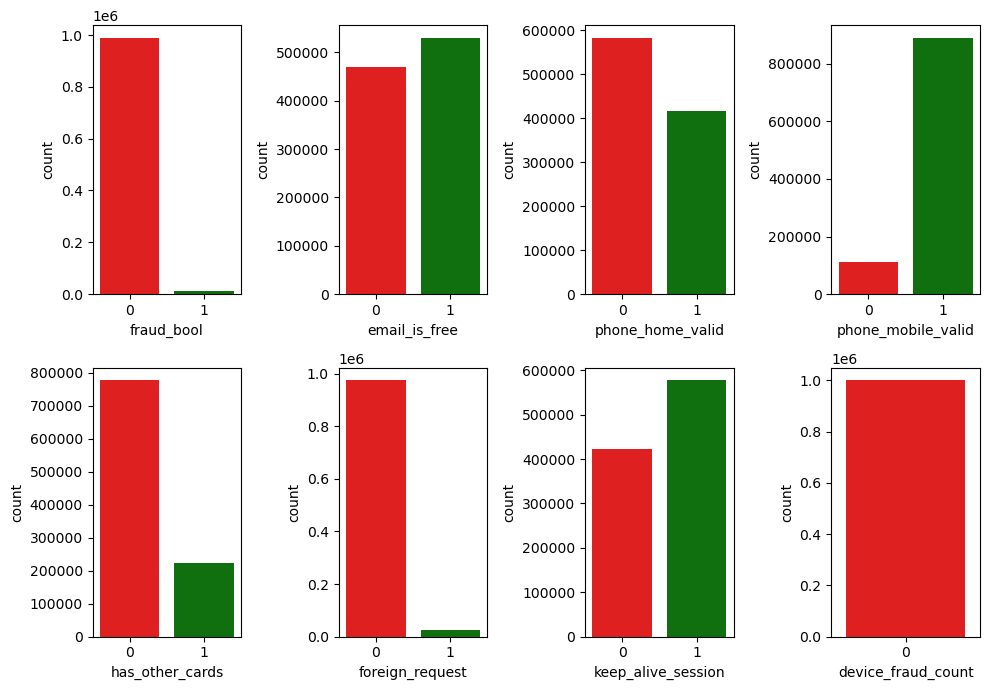

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir la paleta de colores para 1 y 0
colors = {1: 'green', 0: 'red'}

# Convertir las claves del diccionario a cadenas
colors_str = {str(key): value for key, value in colors.items()}

# Visualización de las variables categóricas
fig, axis = plt.subplots(2, 4, figsize = (10, 7))

# Create a multiple histogram
sns.countplot(ax = axis[0, 0], data = baf_num_b, x = "fraud_bool", palette=colors_str)
sns.countplot(ax = axis[0, 1], data = baf_num_b, x = "email_is_free", palette=colors_str)
sns.countplot(ax = axis[0, 2], data = baf_num_b, x = "phone_home_valid", palette=colors_str)
sns.countplot(ax = axis[0, 3], data = baf_num_b, x = "phone_mobile_valid", palette=colors_str)
sns.countplot(ax = axis[1, 0], data = baf_num_b, x = "has_other_cards", palette=colors_str)
sns.countplot(ax = axis[1, 1], data = baf_num_b, x = "foreign_request", palette=colors_str)
sns.countplot(ax = axis[1, 2], data = baf_num_b, x = "keep_alive_session", palette=colors_str)
sns.countplot(ax = axis[1, 3], data = baf_num_b, x = "device_fraud_count", palette=colors_str)


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### **Sub 3.1:** Análisis de datos numéricos no binarios

In [12]:
# Información de los datos numericos binarios
baf_num_nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   income                            1000000 non-null  float64
 1   name_email_similarity             1000000 non-null  float64
 2   current_address_months_count      1000000 non-null  float64
 3   customer_age                      1000000 non-null  int64  
 4   days_since_request                1000000 non-null  float64
 5   zip_count_4w                      1000000 non-null  int64  
 6   velocity_6h                       1000000 non-null  float64
 7   velocity_24h                      1000000 non-null  float64
 8   velocity_4w                       1000000 non-null  float64
 9   bank_branch_count_8w              1000000 non-null  int64  
 10  date_of_birth_distinct_emails_4w  1000000 non-null  int64  
 11  credit_risk_score                 1000

In [13]:
# Descripción de los datos numéricos no binarios
baf_num_nb.describe()

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.562696,0.493694,86.817583,33.689080,1.025705e+00,1572.692049,5665.296605,4769.781965,4856.324016,184.361849,9.503544,130.989595,14.897463,515.851010,7.557278,1.019030,3.288674
std,0.290343,0.289125,88.248728,12.025799,5.381835e+00,1005.374565,3009.380665,1479.212612,919.843934,459.625329,5.033792,69.681812,9.959364,487.559902,8.024671,0.176669,2.209994
min,0.100000,0.000001,0.000000,10.000000,4.036860e-09,1.000000,-170.603072,1300.307314,2825.748405,0.000000,0.000000,-170.000000,1.000000,190.000000,0.000872,0.000000,0.000000
25%,0.300000,0.225216,20.000000,20.000000,7.193246e-03,894.000000,3436.365848,3593.179135,4268.368423,1.000000,6.000000,83.000000,5.000000,200.000000,3.122461,1.000000,1.000000
50%,0.600000,0.492153,53.000000,30.000000,1.517574e-02,1263.000000,5319.769349,4749.921161,4913.436941,9.000000,9.000000,122.000000,15.000000,200.000000,5.122832,1.000000,3.000000
75%,0.800000,0.755567,130.000000,40.000000,2.633069e-02,1944.000000,7680.717827,5752.574191,5488.083356,25.000000,13.000000,178.000000,25.000000,500.000000,8.866131,1.000000,5.000000
max,0.900000,0.999999,428.000000,90.000000,7.845690e+01,6700.000000,16715.565404,9506.896596,6994.764201,2385.000000,39.000000,389.000000,32.000000,2100.000000,85.899143,2.000000,7.000000


In [14]:
# Distribución de las variables numericas no binarias 
fig, ax = plt.subplots(12, 3, figsize=(20, 20))


# Histograma para 'income'
sns.histplot(data = baf_num_nb, x = 'income', ax=ax[0,0], color='blue')
# Boxplot para 'income'
sns.boxplot(data = baf_num_nb, x = 'income', ax=ax[1,0], color='blue')
# Histograma para 'name_email_similarity'
sns.histplot(data = baf_num_nb, x = 'name_email_similarity', ax=ax[0,1], color='blue')
# Boxplot para 'name_email_similarity'
sns.boxplot(data = baf_num_nb, x = 'name_email_similarity', ax=ax[1,1], color='blue')
# Histograma para 'current_address_months_count'
sns.histplot(data = baf_num_nb, x = 'current_address_months_count', ax=ax[0,2], color='blue')
# Boxplot para 'current_address_months_count'
sns.boxplot(data = baf_num_nb, x = 'current_address_months_count', ax=ax[1,2], color='blue')
# Histograma para 'customer_age'
sns.histplot(data = baf_num_nb, x = 'customer_age', ax=ax[2,0], color='blue')
# Boxplot para 'customer_age'
sns.boxplot(data = baf_num_nb, x = 'customer_age', ax=ax[3,0], color='blue')
# Histograma para 'days_since_request'
sns.histplot(data = baf_num_nb, x = 'days_since_request', ax=ax[2,1], color='blue')
# Boxplot para 'days_since_request'
sns.boxplot(data = baf_num_nb, x = 'days_since_request', ax=ax[3,1], color='blue')
# Histograma para 'zip_count_4w'
sns.histplot(data = baf_num_nb, x = 'zip_count_4w', ax=ax[2,2], color='blue')
# Boxplot para 'zip_count_4w'
sns.boxplot(data = baf_num_nb, x = 'zip_count_4w', ax=ax[3,2], color='blue')
# Histograma para 'velocity_6h'
sns.histplot(data = baf_num_nb, x = 'velocity_6h', ax=ax[4,0], color='blue')
# Boxplot para 'velocity_6h'
sns.boxplot(data = baf_num_nb, x = 'velocity_6h', ax=ax[5,0], color='blue')
# Histograma para 'velocity_24h'
sns.histplot(data = baf_num_nb, x = 'velocity_24h', ax=ax[4,1], color='blue')
# Boxplot para 'velocity_24h'
sns.boxplot(data = baf_num_nb, x = 'velocity_24h', ax=ax[5,1], color='blue')
# Histograma para 'velocity_4w'
sns.histplot(data = baf_num_nb, x = 'velocity_4w', ax=ax[4,2], color='blue')
# Boxplot para 'velocity_4w'
sns.boxplot(data = baf_num_nb, x = 'velocity_4w', ax=ax[5,2], color='blue')
# Histograma para 'bank_branch_count_8w'
sns.histplot(data = baf_num_nb, x = 'bank_branch_count_8w', ax=ax[6,0], color='blue')
# Boxplot para 'bank_branch_count_8w'
sns.boxplot(data = baf_num_nb, x = 'bank_branch_count_8w', ax=ax[7,0], color='blue')
# Histograma para 'date_of_birth_distinct_emails_4w'
sns.histplot(data = baf_num_nb, x = 'date_of_birth_distinct_emails_4w', ax=ax[6,1], color='blue')
# Boxplot para 'date_of_birth_distinct_emails_4w'
sns.boxplot(data = baf_num_nb, x = 'date_of_birth_distinct_emails_4w', ax=ax[7,1], color='blue')
# Histograma para 'credit_risk_score'
sns.histplot(data = baf_num_nb, x = 'credit_risk_score', ax=ax[6,2], color='blue')
# Boxplot para 'credit_risk_score'
sns.boxplot(data = baf_num_nb, x = 'credit_risk_score', ax=ax[7,2], color='blue')
# Histograma para 'bank_months_count'
sns.histplot(data = baf_num_nb, x = 'bank_months_count', ax=ax[8,0], color='blue')
# Boxplot para 'bank_months_count'
sns.boxplot(data = baf_num_nb, x = 'bank_months_count', ax=ax[9,0], color='blue')
# Histograma para 'proposed_credit_limit'
sns.histplot(data = baf_num_nb, x = 'proposed_credit_limit', ax=ax[8,1], color='blue')
# Boxplot para 'proposed_credit_limit'
sns.boxplot(data = baf_num_nb, x = 'proposed_credit_limit', ax=ax[9,1], color='blue')
# Histograma para 'session_length_in_minutes'
sns.histplot(data = baf_num_nb, x = 'session_length_in_minutes', ax=ax[8,2], color='blue')
# Boxplot para 'session_length_in_minutes'
sns.boxplot(data = baf_num_nb, x = 'session_length_in_minutes', ax=ax[9,2], color='blue')
# Histograma para 'device_distinct_emails_8w'
sns.histplot(data = baf_num_nb, x = 'device_distinct_emails_8w', ax=ax[10,0], color='blue')
# Boxplot para 'device_distinct_emails_8w'
sns.boxplot(data = baf_num_nb, x = 'device_distinct_emails_8w', ax=ax[11,0], color='blue')
# Histograma para 'month'
sns.histplot(data = baf_num_nb, x = 'month', ax=ax[10,1], color='blue')
# Boxplot para 'month'
sns.boxplot(data = baf_num_nb, x = 'month', ax=ax[11,1], color='blue')

plt.show()